In [1]:
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
state_lookup = pd.read_csv('./census_geometry/state_lookup.csv')

mi = gpd.GeoDataFrame()

for i in range(0, 57):
    temp_path = f'./MH_F_Results/{i}/MH_F_mi.geojson'
    if os.path.exists(temp_path):
        temp_ = gpd.read_file(temp_path)
        mi = pd.concat([mi, temp_], ignore_index=True)
    
mi = mi.fillna(0)
mi['STATE'] = mi.apply(lambda x:x['ID'][0:2], axis=1)
mi = mi.merge(state_lookup, left_on='STATE', right_on='Abbr', how='left')
mi

,ID,LAT,LON,NAME,LIBRARY_ID,LIBRARY_TYPE,MH_F,IH_F,TAS_F,SS_F,...,pval_NOVEH,MI_GROUPQ,pval_GROUPQ,geometry,STATE,Name,Abbr,FIPS,ContiguousUS,Region
0,CO01283S001,38.072333,-103.129028,JOHN MARTIN DAM - FORT LYON LEVEE,1007,dam_study,True,False,True,True,...,0.000000e+00,0.000000,0.000000e+00,POINT (-103.12903 38.07233),CO,Colorado,CO,8,1,Mountain
1,CA10016,33.891670,-117.925000,BREA DAM,274,dam_study,True,False,True,True,...,5.980402e-02,-0.019072,1.990704e-01,POINT (-117.92500 33.89167),CA,California,CA,6,1,Pacific
2,OH00004S002,40.650549,-81.300936,BOLIVAR DAM - MAGNOLIA LEVEE,243,dam_study,True,False,True,False,...,3.488577e-02,0.000000,0.000000e+00,POINT (-81.30094 40.65055),OH,Ohio,OH,39,1,EastNorthCentral
3,CA10024,34.113331,-117.968300,SANTA FE DAM,320,dam_study,True,False,True,True,...,9.886250e-02,-0.167960,2.257229e-14,POINT (-117.96830 34.11333),CA,California,CA,6,1,Pacific
4,CA10017,33.914578,-117.840063,CARBON CANYON DAM,309,dam_study,True,False,True,True,...,2.672456e-03,-0.029437,1.511771e-02,POINT (-117.84006 33.91458),CA,California,CA,6,1,Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,OK10318,36.549055,-99.560571,FORT SUPPLY DAM,4203,dam_study,True,False,True,True,...,2.068243e-08,-0.064407,9.372214e-08,POINT (-99.56057 36.54905),OK,Oklahoma,OK,40,1,WestSouthCentral
451,MS01494,33.821629,-89.772394,GRENADA DAM,5646,dam_study,True,True,True,True,...,8.135002e-29,-0.103514,6.472852e-27,POINT (-89.77239 33.82163),MS,Mississippi,MS,28,1,EastSouthCentral
452,CA10244,37.110662,-119.884580,HIDDEN DAM,5887,dam_study,True,True,True,True,...,4.544004e-03,0.169209,0.000000e+00,POINT (-119.88458 37.11066),CA,California,CA,6,1,Pacific
453,CA10019,34.260981,-118.386759,HANSEN DAM,1503,dam_study,True,False,True,True,...,1.423031e-14,0.076261,0.000000e+00,POINT (-118.38676 34.26098),CA,California,CA,6,1,Pacific


In [8]:
# str: single variable
# list: [[To be summed and set as numerator], demonimator]  
census_info = {
                "EP_POV150" : [['S1701_C01_040E'], 'S1701_C01_001E'],
                "EP_UNEMP"  : 'DP03_0009PE',
                "EP_HBURD"  : [['S2503_C01_028E', 'S2503_C01_032E', 'S2503_C01_036E', 'S2503_C01_040E'], 
                            'S2503_C01_001E'],
                "EP_NOHSDP" : 'S0601_C01_033E',
                "EP_UNINSUR" : 'S2701_C05_001E',
                "EP_AGE65" : 'S0101_C02_030E',
                "EP_AGE17" : [['B09001_001E'], 
                            'S0601_C01_001E'],
                "EP_DISABL" : 'DP02_0072PE',
                "EP_SNGPNT" : [['B11012_010E', 'B11012_015E'], 'DP02_0001E'],
                "EP_LIMENG" : [['B16005_007E', 'B16005_008E', 'B16005_012E', 'B16005_013E', 'B16005_017E', 'B16005_018E', 
                                'B16005_022E', 'B16005_023E', 'B16005_029E', 'B16005_030E', 'B16005_034E', 'B16005_035E',
                                'B16005_039E', 'B16005_040E', 'B16005_044E', 'B16005_045E'], 
                            'B16005_001E'],
                "EP_MINRTY" : [['DP05_0071E', 'DP05_0078E', 'DP05_0079E', 'DP05_0080E', 
                                'DP05_0081E', 'DP05_0082E', 'DP05_0083E'],
                            'S0601_C01_001E'],
                "EP_MUNIT" : [['DP04_0012E', 'DP04_0013E'], 
                            'DP04_0001E'],
                "EP_MOBILE" : 'DP04_0014PE',
                "EP_CROWD" : [['DP04_0078E', 'DP04_0079E'], 
                            'DP04_0002E'],
                "EP_NOVEH" : 'DP04_0058PE',
                "EP_GROUPQ": [['B26001_001E'], 
                            'S0601_C01_001E'],
}
plot_cols_mi = ['MI_' + col.split('_')[1] for col in census_info.keys()]
plot_cols_mi

['MI_POV150',
 'MI_UNEMP',
 'MI_HBURD',
 'MI_NOHSDP',
 'MI_UNINSUR',
 'MI_AGE65',
 'MI_AGE17',
 'MI_DISABL',
 'MI_SNGPNT',
 'MI_LIMENG',
 'MI_MINRTY',
 'MI_MUNIT',
 'MI_MOBILE',
 'MI_CROWD',
 'MI_NOVEH',
 'MI_GROUPQ']

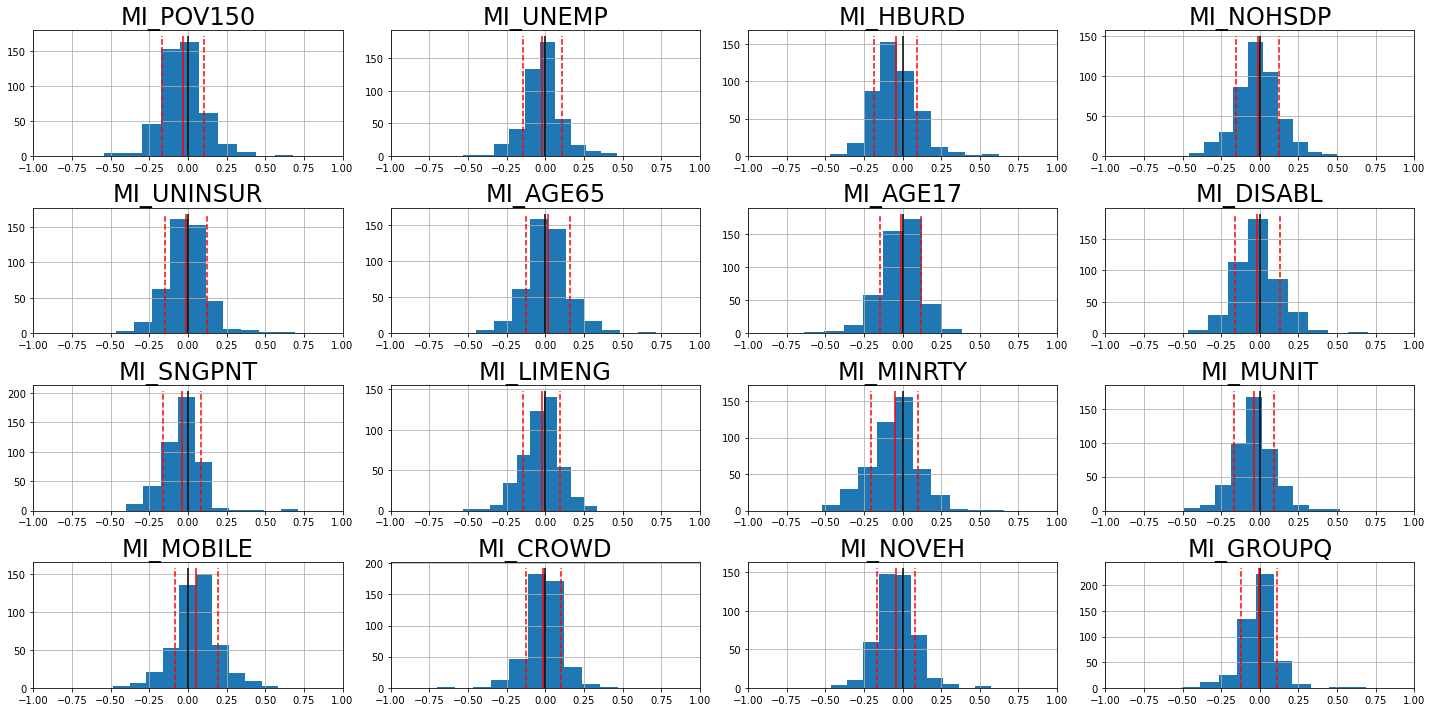

In [9]:
mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]

for col in mi_.columns:
    mi_ = mi_.loc[pd.notna(mi_[col])]
    
mi_

fig, axes = plt.subplots(4, 4, figsize=(20,10))
ax = axes.reshape(-1)

for idx, col in enumerate(plot_cols_mi):
    mi_[col].hist(ax=ax[idx])
    
    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='black')
    ax[idx].vlines(mi_[col].mean(), 0, ylim, color='red')
    ax[idx].vlines(mi_[col].mean() - mi_[col].std(), 0, ylim, color='red', linestyle='dashed')
    ax[idx].vlines(mi_[col].mean() + mi_[col].std(), 0, ylim, color='red', linestyle='dashed')
    
    ax[idx].set_title(label=f"{col}", fontsize=24)
    ax[idx].set_xlim(-1, 1)
    
plt.tight_layout()
plt.show()
    

## Divide dams into 9 regions 

https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
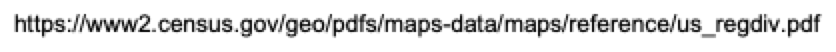

EastSouthCentral 42


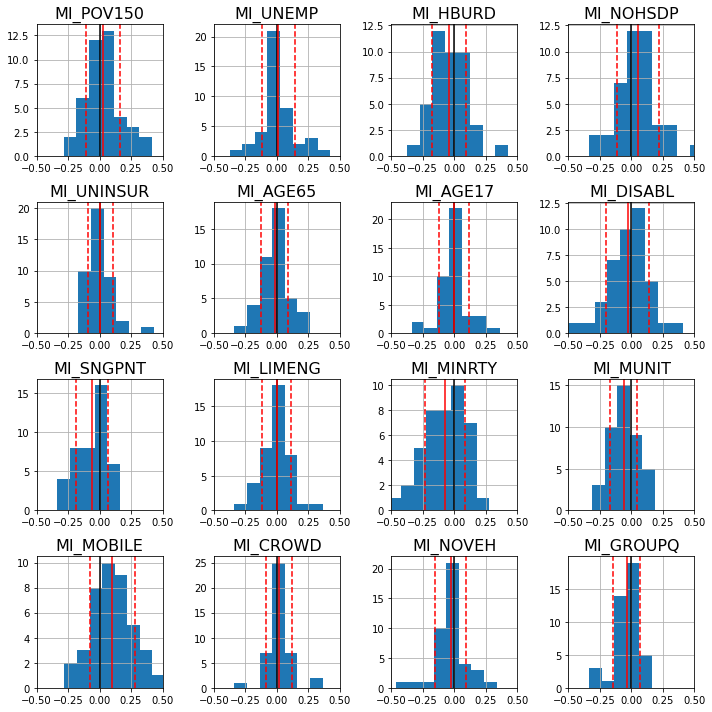

Pacific 58


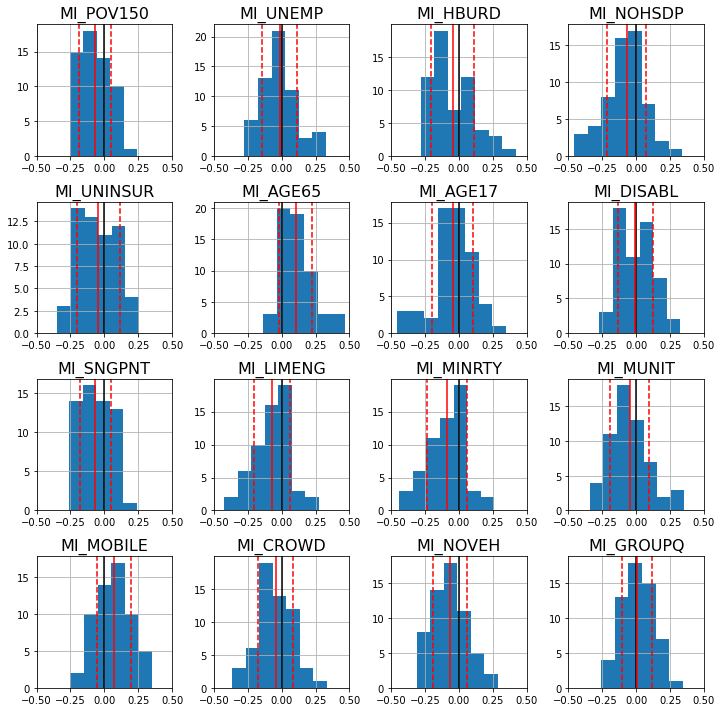

Mountain 26


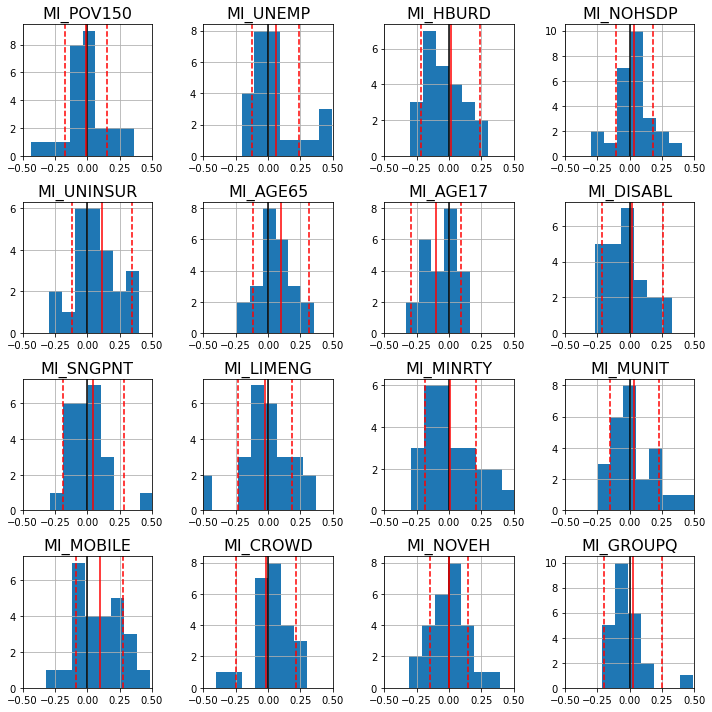

WestSouthCentral 80


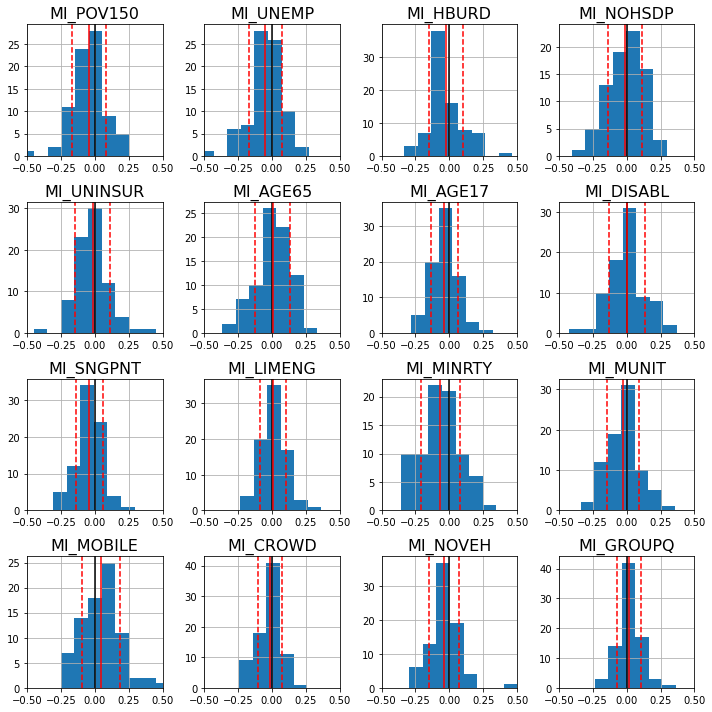

NewEngland 45


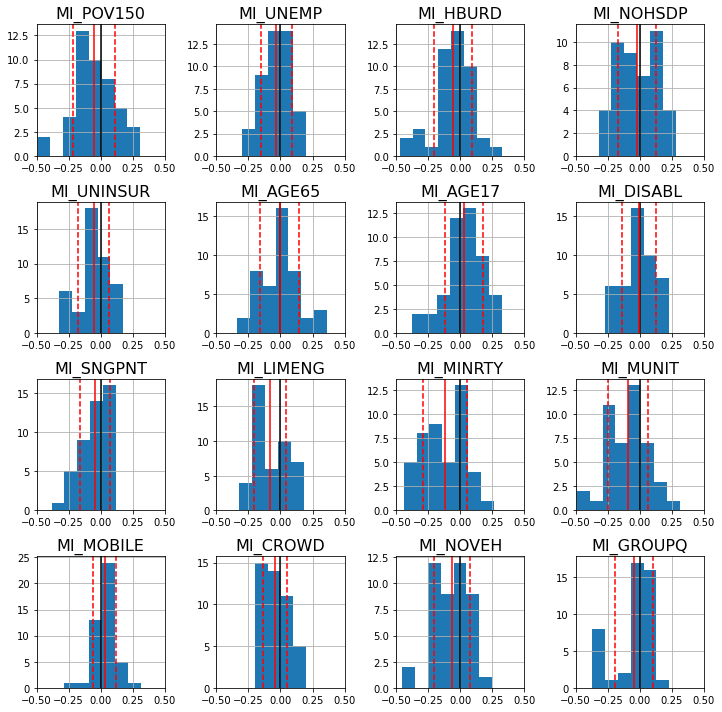

SouthAtlantic 41


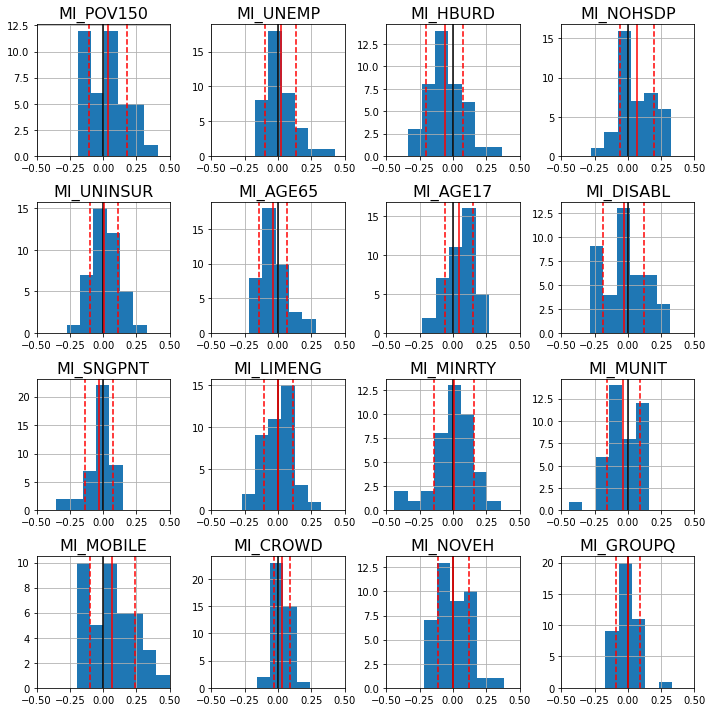

EastNorthCentral 60


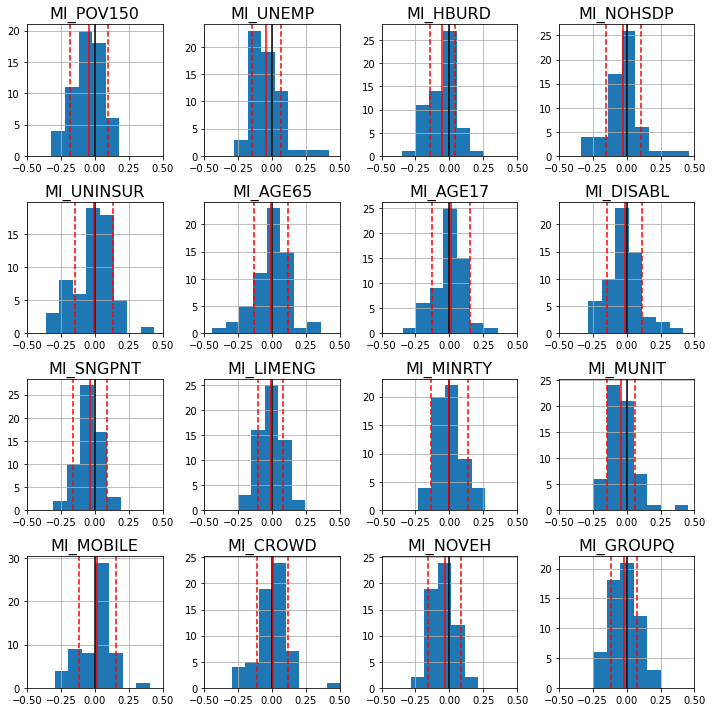

WestNorthCentral 72


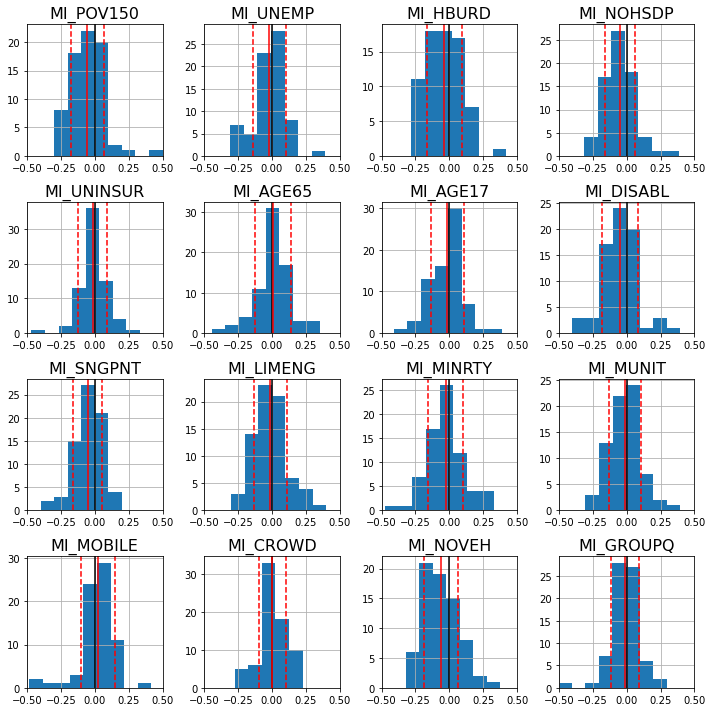

MiddleAtlantic 31


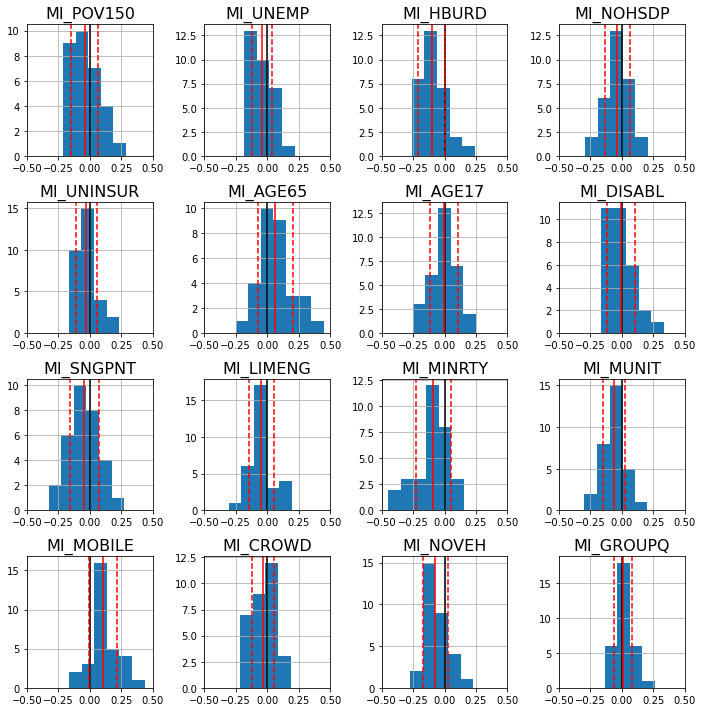

In [10]:
for region in state_lookup['Region'].unique():

    if type(region) == str:

        mi_ = mi.loc[mi['Region'] == region, [col for col in mi.columns if col.startswith('MI')]]
        print(region, mi_.shape[0])
        
        fig, axes = plt.subplots(4, 4, figsize=(10,10))
        ax = axes.reshape(-1)

        binwidth = 0.1
        for idx, col in enumerate(plot_cols_mi):
            mi_[col].hist(ax=ax[idx], bins=np.arange(min(mi_[col]), max(mi_[col]) + binwidth, binwidth))
            ylim = ax[idx].get_ylim()[1]
            ax[idx].vlines(0, 0, ylim, color='black')
            ax[idx].vlines(mi_[col].mean(), 0, ylim, color='red')
            ax[idx].vlines(mi_[col].mean() - mi_[col].std(), 0, ylim, color='red', linestyle='dashed')
            ax[idx].vlines(mi_[col].mean() + mi_[col].std(), 0, ylim, color='red', linestyle='dashed')
            
            ax[idx].set_title(label=f"{col}", fontsize=16)
            ax[idx].set_xlim(-0.5, 0.5)
            ax[idx].set_ylim(0, ylim)

        plt.tight_layout()
        plt.show()


EastSouthCentral
EastSouthCentral | optimal cluster count: 2


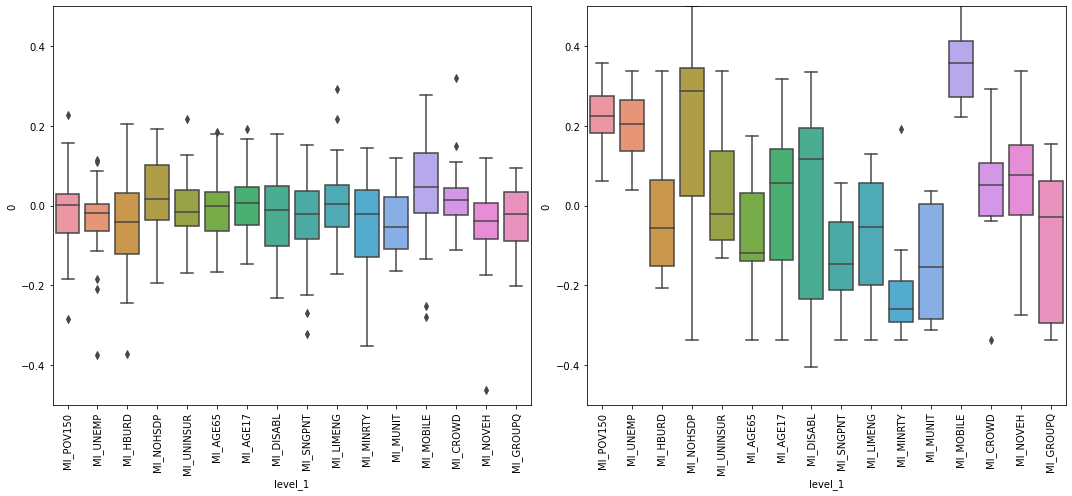

Pacific
Pacific | optimal cluster count: 3


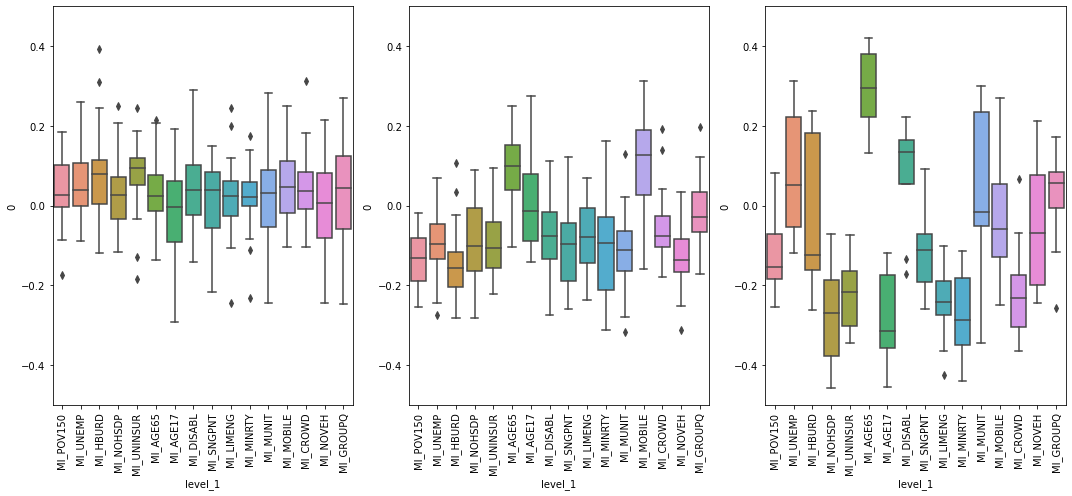

Mountain
Mountain | optimal cluster count: 2


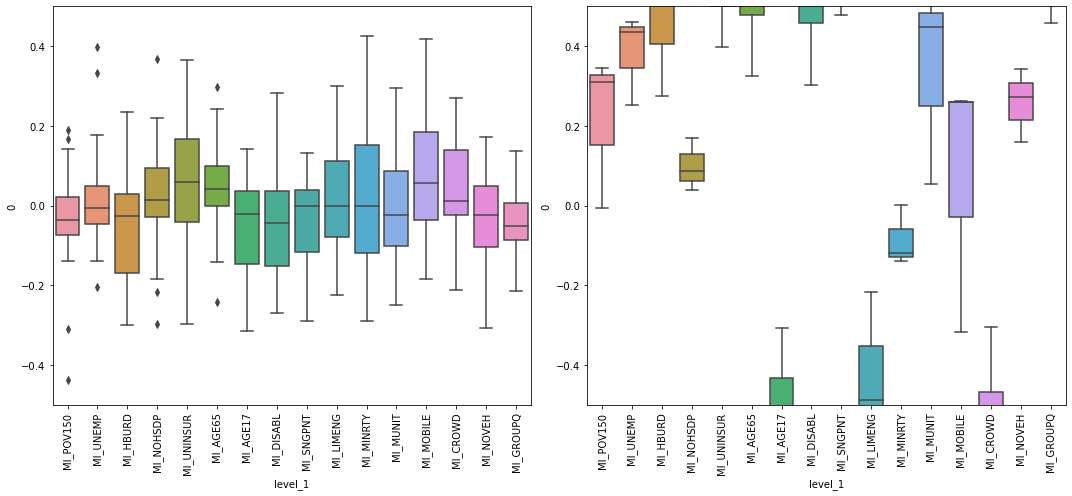

WestSouthCentral
WestSouthCentral | optimal cluster count: 2


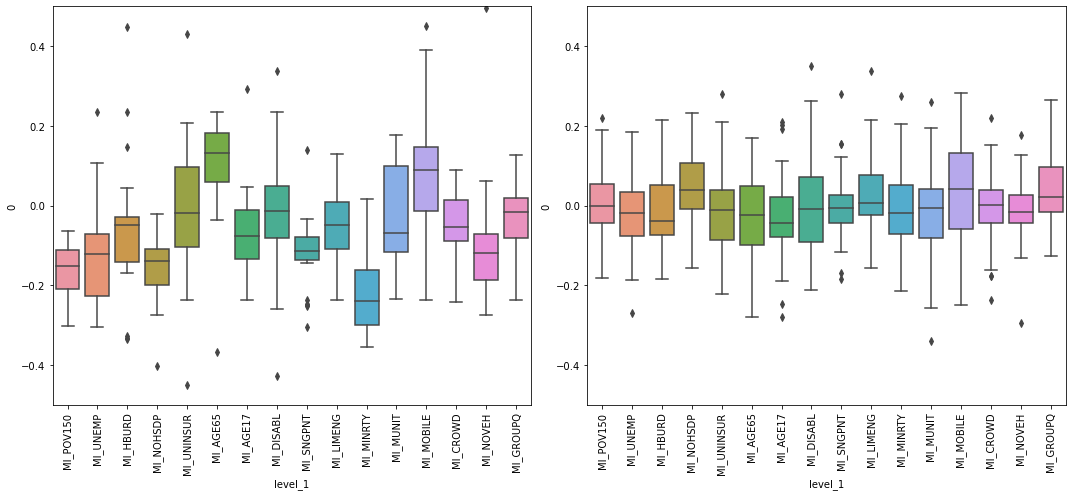

NewEngland
NewEngland | optimal cluster count: 4


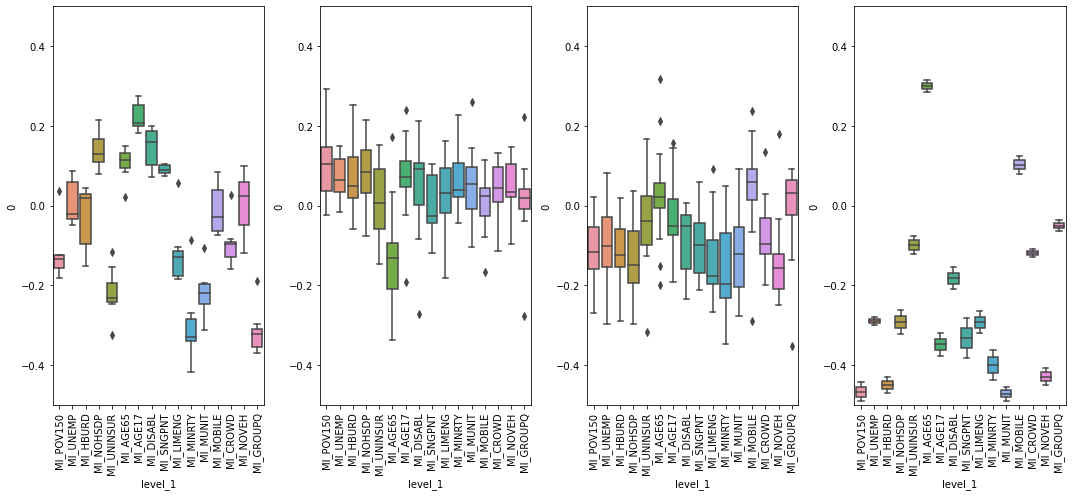

SouthAtlantic
SouthAtlantic | optimal cluster count: 10


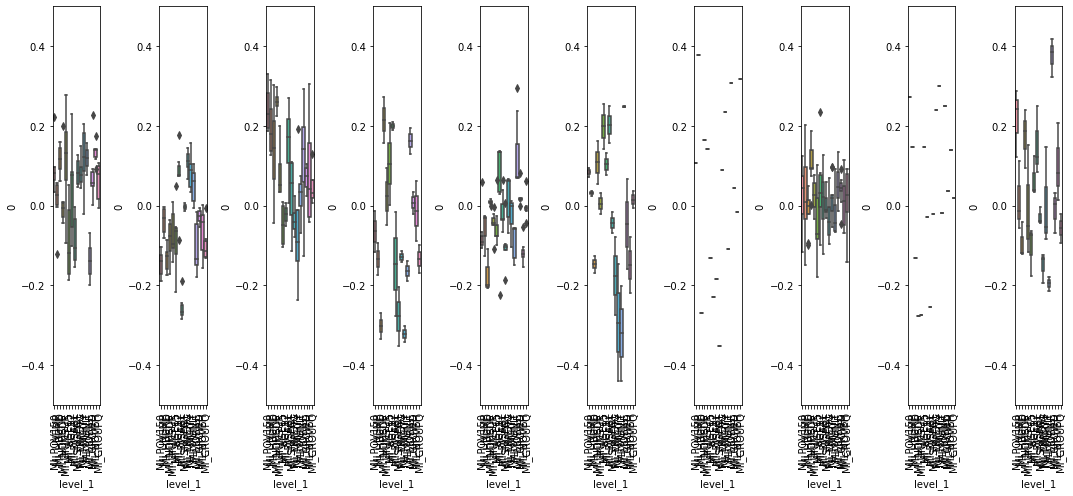

EastNorthCentral
EastNorthCentral | optimal cluster count: 2


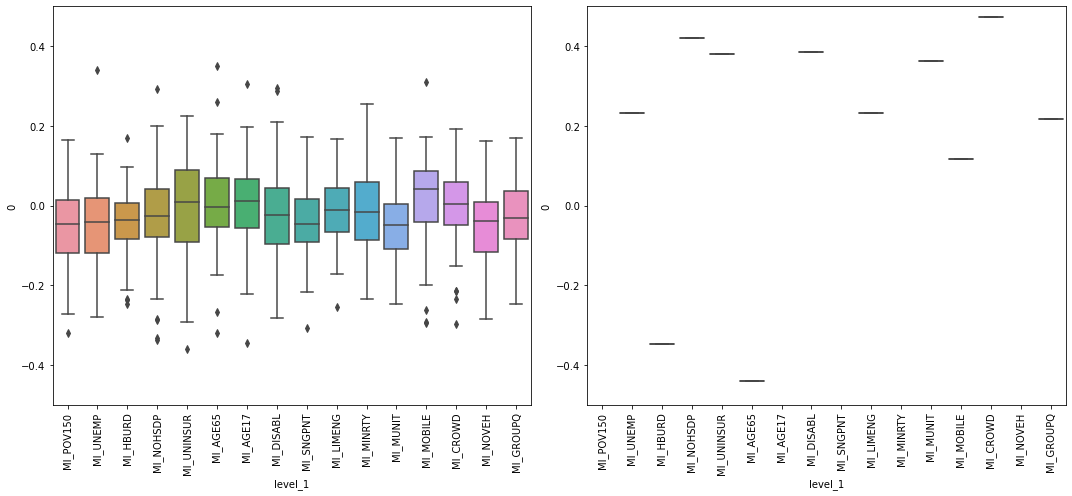

WestNorthCentral
WestNorthCentral | optimal cluster count: 4


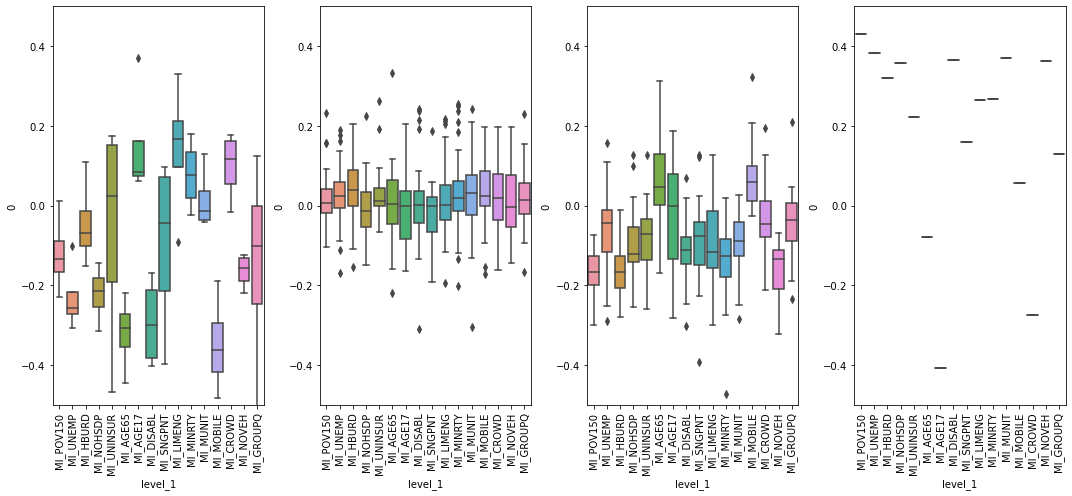

MiddleAtlantic
MiddleAtlantic | optimal cluster count: 2


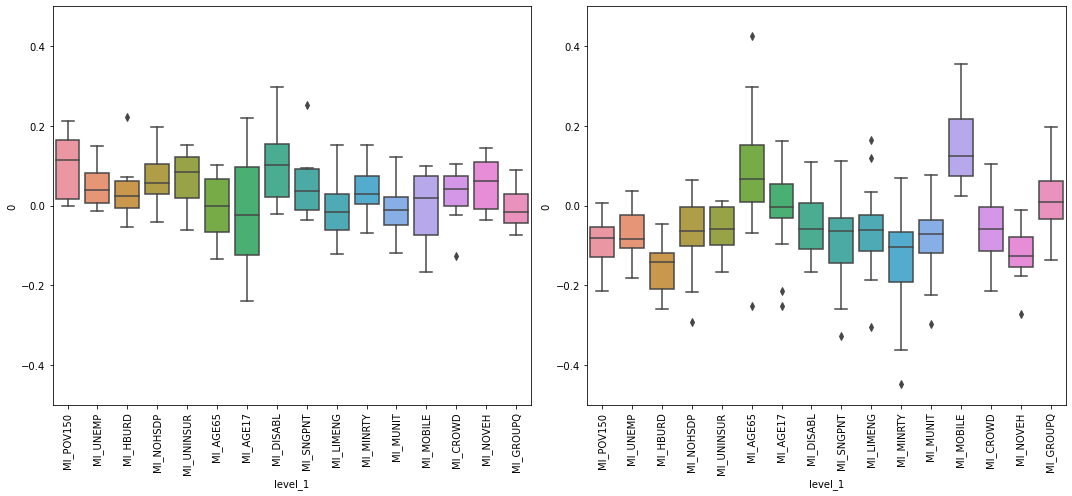

In [48]:
def determine_number_of_cluster(array):
    km_cost = []  # Sum of squared distances of samples to their closest cluster center.
    distortions = []  # the average of the squared distances from the cluster centers of the respective clusters.Typically, the Euclidean distance metric is used.
    km_silhouette = {}

    for i in range(2, 11):
        KM = KMeans(n_clusters=i, max_iter=999, n_init = 99, random_state=17)
        KM.fit(array)

        # Calculate Silhouette Scores
        preds = KM.predict(array)
        silhouette = silhouette_score(array, preds)
        km_silhouette[i] = silhouette

#     print(max(km_silhouette, key=km_silhouette.get))
#     print(km_silhouette)
        
    return km_silhouette

def kmeans_cluster(array, num_of_cluster):
    kmeans = KMeans(n_clusters=num_of_cluster, max_iter=999, n_init = 99, random_state=17)
    kmeans.fit(array)
    y_kmeans = kmeans.predict(array)
    
    cluster_df = pd.DataFrame({'cluster': y_kmeans}, index=array.index)
    
    return cluster_df


for region in state_lookup['Region'].unique():

    if type(region) == str:
        print(region)
        mi_ = mi.loc[mi['Region'] == region, [col for col in mi.columns if col.startswith('MI')]]
        sil_coef = determine_number_of_cluster(mi_)
        print(f"{region} | optimal cluster count: {max(sil_coef, key=sil_coef.get)}")
        
        opt_cluster = max(sil_coef, key=sil_coef.get)
        
        cluster_mi = kmeans_cluster(mi_, opt_cluster)
        
        fig, ax = plt.subplots(1, opt_cluster, figsize=(15, 7))
        
        for c in range(opt_cluster):
            temp_cluster = mi_.loc[cluster_mi['cluster'] == c].stack().reset_index()
            sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
            ax[c].set_ylim(-0.5, 0.5)
            ax[c].set_xticklabels([col for col in mi.columns if col.startswith('MI')], rotation = 'vertical')

        plt.tight_layout()
        plt.show()

In [ ]:
determine_number_of_cluster(mi_[['MI_POV150', 'MI_UNEMP', 'MI_HBURD', 'MI_NOHSDP', 'MI_UNINSUR']])

In [ ]:
aa = kmeans_cluster(mi_[['MI_POV150', 'MI_UNEMP', 'MI_HBURD', 'MI_NOHSDP', 'MI_UNINSUR']], 2)

group_0 = mi_.loc[aa['cluster'] == 0, ['MI_POV150', 'MI_UNEMP', 'MI_HBURD', 'MI_NOHSDP', 'MI_UNINSUR']].stack().reset_index()
group_1 = mi_.loc[aa['cluster'] == 1, ['MI_POV150', 'MI_UNEMP', 'MI_HBURD', 'MI_NOHSDP', 'MI_UNINSUR']].stack().reset_index()
# group_2 = mi_.loc[aa['cluster'] == 2].stack().reset_index()

In [ ]:
print(len(group_0['level_0'].unique()))
print(len(group_1['level_0'].unique()))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

sns.boxplot(x = 'level_1', y = 0, data=group_0, ax=ax[0])
sns.boxplot(x = 'level_1', y = 0, data=group_1, ax=ax[1])
# sns.boxplot(x = 'level_1', y = 0, data=group_2, ax=ax[2])
# sns.boxplot(x = 'level_1', y = 0, data=group_3, ax=ax[3])


ax[0].set_ylim(-0.3, 0.3)
ax[1].set_ylim(-0.3, 0.3)
# ax[2].set_ylim(-0.3, 0.3)
# ax[3].set_ylim(-0.3, 0.3)

In [ ]:
def kmeans_cluster(array, num_of_cluster):
    kmeans = KMeans(n_clusters=num_of_cluster, max_iter=999, n_init = 99, random_state=17)
    kmeans.fit(array)
    y_kmeans = kmeans.predict(array)
    
    cluster_df = pd.DataFrame({'cluster': y_kmeans}, index=array.index)
    
    return cluster_df

aa = kmeans_cluster(mi_, 3)

In [ ]:
group_0 = mi_.loc[aa['cluster'] == 0].stack().reset_index()
group_1 = mi_.loc[aa['cluster'] == 1].stack().reset_index()
group_2 = mi_.loc[aa['cluster'] == 2].stack().reset_index()
# group_3 = mi_.loc[aa['cluster'] == 3].stack().reset_index()

In [ ]:
len(group_0['level_0'].unique())

In [ ]:
len(group_1['level_0'].unique())

In [ ]:
len(group_2['level_0'].unique())

In [ ]:
len(group_3['level_0'].unique())

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

sns.boxplot(x = 'level_1', y = 0, data=group_0, ax=ax[0])
sns.boxplot(x = 'level_1', y = 0, data=group_1, ax=ax[1])
sns.boxplot(x = 'level_1', y = 0, data=group_2, ax=ax[2])
# sns.boxplot(x = 'level_1', y = 0, data=group_3, ax=ax[3])


ax[0].set_ylim(-0.3, 0.3)
ax[1].set_ylim(-0.3, 0.3)
ax[2].set_ylim(-0.3, 0.3)
# ax[3].set_ylim(-0.3, 0.3)